In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
from tensorflow import keras
import os 
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import random
import tensorflow as tf

In [31]:
class HandLandmark:
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    MODEL_PATH = None
    OUTPUT_IMG_SHAPE = (40, 40)

    custom_landmark_spec = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4) 
    custom_connection_spec = mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)

    landmark_colors = {
        0: (255, 0, 0),    
        1: (255, 165, 0),  # Thumb
        2: (255, 165, 0),
        3: (255, 165, 0),
        4: (255, 165, 0),
        5: (0, 255, 0),    # Index
        6: (0, 255, 0),
        7: (0, 255, 0),
        8: (0, 255, 0),
        9: (0, 255, 255),  # Middle
        10: (0, 255, 255),
        11: (0, 255, 255),
        12: (0, 255, 255),
        13: (255, 0, 255), # Ring
        14: (255, 0, 255),
        15: (255, 0, 255),
        16: (255, 0, 255),
        17: (0, 0, 255),   # Pinky
        18: (0, 0, 255),
        19: (0, 0, 255),
        20: (0, 0, 255)
    }

    def fit(self, frame: np.ndarray):
        self.frame = frame

    def co_ordinates_finder(self, results) -> tuple:
        """Args: results (process result from mediapipe model)
           Return: tuple with co-ordinates (x_min, x_max, y_min, y_max)"""
        output_image = np.zeros_like(self.frame)
        x_min, y_min = float('inf'), float('inf')  
        x_max, y_max = float('-inf'), float('-inf')
        
        for hand_landmarks in results.multi_hand_landmarks:
            self.mp_drawing.draw_landmarks(
                image=output_image,
                landmark_list=hand_landmarks,
                connections=self.mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=None,
                connection_drawing_spec=self.custom_connection_spec
            )
            
            for idx, landmark in enumerate(hand_landmarks.landmark):
                h, w, _ = self.frame.shape
                cx, cy = int(landmark.x * w), int(landmark.y * h)
                cv2.circle(self.frame, (cx, cy), 5, self.landmark_colors.get(idx, (255, 255, 255)), -1)
                cv2.circle(output_image, (cx, cy), 5, self.landmark_colors.get(idx, (255, 255, 255)), -1)
                x_min = min(x_min, cx)
                y_min = min(y_min, cy)
                x_max = max(x_max, cx)
                y_max = max(y_max, cy)
                
        co_ordinates = (x_min, x_max, y_min, y_max)
        return output_image, co_ordinates
        
    def landmark_result(self) -> tuple:
        """Processes the frame to detect hand landmarks."""
        self.frame = cv2.cvtColor(cv2.flip(self.frame, 1), cv2.COLOR_BGR2RGB)
        self.frame.flags.writeable = False
        results = self.hands.process(self.frame)
        self.frame.flags.writeable = True
        self.frame = cv2.cvtColor(self.frame, cv2.COLOR_RGB2BGR)
        return results
    
    def process_image(self) -> tuple:
        results = self.landmark_result()
        if results.multi_hand_landmarks:
            output_image, co_ordinates = self.co_ordinates_finder(results=results)
        else:
            co_ordinates = None
            output_image = self.frame
        return output_image, co_ordinates

    def cropper_resizer(self, frame: np.ndarray, x_min: int, x_max: int, y_min: int, y_max: int) -> np.ndarray:
        cropped_image = frame[y_min:y_max, x_min:x_max] 
        cropped_image = cv2.resize(cropped_image, self.OUTPUT_IMG_SHAPE)
        return cropped_image
                
    def frame_process(self) -> dict:
        """Processes the frame to detect and crop the hand region.
        {'co_ordinates': co_ordinates, 'cropped_image': cropped_image, 'output_image': output_image, 'original_image': self.frame}"""
        self.hands = self.mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5)
        output_image, co_ordinates = self.process_image()
        if co_ordinates is not None:
            x_min, x_max, y_min, y_max = co_ordinates
            cropped_image = self.cropper_resizer(output_image, x_min, x_max, y_min, y_max)
        else:
            cropped_image = None
        self.hands.close()
        return {'co_ordinates': co_ordinates, 'cropped_image': cropped_image, 'output_image': output_image, 'original_image': self.frame}
    
    def predict(self, image: np.ndarray) -> int:
        """Predicts the hand gesture class."""
        if self.MODEL_PATH is None:
            raise ValueError("MODEL_PATH is not defined. Please set MODEL_PATH to the model's file path.")
        
        model = keras.models.load_model(self.MODEL_PATH)
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = tf.expand_dims(image, 0)  # Add batch dimension
        prediction = model.predict(image)
        return np.argmax(prediction)


In [42]:
test_images = {}
for i, folder in enumerate(FOLDERS):
    test_images[i] = []
    for img_name in os.listdir(folder)[:50]:
        img = cv2.imread(os.path.join(folder, img_name)) 
        img = cv2.resize(img, (40, 40))
        test_images[i].append(img)

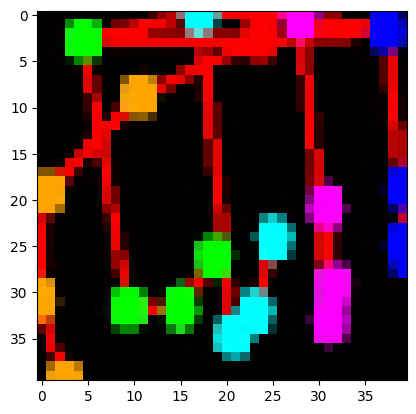

In [43]:
plt.imshow(test_images[0][0])
plt.show()

In [44]:
DATA_ROOT = "Data\\Test"
MODEL_ROOT = "Trained Models"
FOLDERS = [os.path.join(ROOT, path) for path in os.listdir(ROOT)]
recognizer = HandLandmark()
recognizer.MODEL_PATH = os.path.join(MODEL_ROOT, '2024-08-31 00-37-55.keras')
recognizer.OUTPUT_IMG_SHAPE = (40,40)

In [46]:
y_pred = []
for label,images in test_images.items():
    for img in images:
        res = recognizer.predict(img)
        y_pred.append(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━

In [54]:
y_test = np.concatenate([[label] * 50 for label in test_images.keys()])

In [ ]:
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, precision_score, recall_score, f1_score